In [1]:
# Imports

# Dwave imports
from dimod import SimulatedAnnealingSampler
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod
from __future__ import print_function
import dimod
import math
import sys
import copy
import hybrid
from dimod import ExactSolver
from dimod.generators.constraints import combinations
from hybrid.reference import KerberosSampler

#Impots for QUBO problem
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib as plt
import itertools as it
from itertools import product
from matplotlib import pyplot as plt
import math

import matplotlib.pyplot as plt
import networkx as nx

import ast
from ast import literal_eval as make_list

All additional information is in the notes written with the Micheletti paper that this code aims to recreate 

In [2]:
# Header template:


'''
LOGIC:

INPUTS:

OUTPUTS:

'''

'\nLOGIC:\n\nINPUTS:\n\nOUTPUTS:\n\n'

In [3]:
# Code to find the set of indicies that are next to vertex p. Verticies are labeled numerically from 0 to N^2 - 1
# We note that the index can be encoded as a tuple via p = px*n+py, hence py = p mod n and px = (i - iy)/n

def next_to(p,n,T):
    '''
    LOGIC:
        Starting from the integer position value of a vertix, find the (x,y) coords using (x,y) = ((p-py)//n, p % n)

    INPUTS:
        p   : Tuple of integer position value and colour key
        n   : Grid size (nxn)
        T   : Boundary conitions

    OUTPUTS:
        neighbours  : List containing the neighbours of each input p on a grid of size (nxn) with boundary conditions T
    '''
    p = p[0]
    if T == 'Default':
        py = p % n # the y coordinate (y in {0,...,n-1})
        px = (p - py)//n # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []
        if px + 1 < n and px + 1 >= 0:
            adjacent_set.append((px + 1, py))
        if px - 1 < n and px - 1 >= 0:
            adjacent_set.append((px - 1, py))
        if py + 1 < n and py + 1 >= 0:
            adjacent_set.append((px, py + 1))
        if py - 1 < n and py - 1 >= 0:
            adjacent_set.append((px, py - 1))
        tensors = []
        neighbours = []


    elif T == 'Periodic':
        py = int(p % n) # the y coordinate (y in {0,...,n-1})
        px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []
        adjacent_set.append(((px + 1) % n, py))
        adjacent_set.append(((px - 1) % n, py))
        adjacent_set.append((px, (py + 1) % n))
        adjacent_set.append((px, (py - 1) % n))
        tensors = []
        neighbours = []
        # print(f'G_{p}')



    elif T == 'X Shift':
        shift = 1
        py = int(p % n) # the y coordinate (y in {0,...,n-1})
        px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []


        #Bulk
        if px not in [0,n-1]:
            adjacent_set.append(((px + 1) % n, py))
            adjacent_set.append(((px - 1) % n, py))
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n))
            # print('Bulk point: ',adjacent_set)
        #x lower boundary
        elif px == 0:
            adjacent_set.append(((px + 1) % n, py))
            adjacent_set.append(((px - 1) % n, (py - shift) % n))
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n))
            # print('lower x point: ', adjacent_set)
        #x upper boundary
        elif px == n-1:
            adjacent_set.append(((px + 1) % n, (py + shift) % n))
            adjacent_set.append(((px - 1) % n, py % n))
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n))
            # print('upper x point: ', adjacent_set)

    neighbours = []
    for x,y in adjacent_set:
        neighbours.append(x*n + y)
    return neighbours


# Get all bonds globally
def get_all_bonds_global(n,colours):
    '''
    LOGIC:
        Find all the edges on the graph by iterating over everypoint and finding their neightbours using the "edge_set(p,n)" function.

    INPUTS:
        n   : Grid size (nxn)

    OUTPUTS:
        bonds   : List of all edges
    '''
    bonds = []
    for C in colours:
        for j in range(n**2):
            for c in colours:
                for p in next_to((j,C),n, T = BC):
                    bonds.append(bond_map(f'G_{j}_{p}_{C}_{c}'))
                    bonds = list(set(bonds))
    return bonds

# Get all local bonds
def get_all_bonds(j,n,colours):
    '''
    LOGIC:
        Find the set of edges connected to vertex p on a grid of size (nxn) using the "nexy_to(p,n,T)" function ordered from low to high.

    INPUTS:
        j   : (integer,string)
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set    : List of rank 2 tensors representing the edges
    '''
    bonds = []
    for cp in colours:
        for p in next_to(j,n, T = BC):
            bonds.append(bond_map(f'G_{j[0]}_{p}_{j[1]}_{cp}'))
    bonds = list(set(bonds))
    return bonds

#get all local interactions
def get_all_non_bond_interactions(n,colours):
    '''LOGIC:
        Find the set of edges connected to vertex p on a grid of size (nxn) using the "nexy_to(p,n,T)" function ordered from low to high.

    INPUTS:
        j   : (integer,string)
        n   : Grid size (nxn)

    OUTPUTS:
        bond_set    : List of rank 2 tensors representing the edges'''
    inter = []
    for j in range(n**2):
        for cj in colours:
            for cp in colours:
                for p in next_to((j,cj),n, T = BC):
                    inter.append(bond_map(f'I_{j}_{p}_{cj}_{cp}'))
    inter = list(set(inter))
    return inter


# Bond map G_j_i -> G_i_j where i < j
def bond_map(bond):
    '''
    LOGIC:
        Ensure the uniqueness of every rank 2 tensor by ordering the indicies from high to low. The inout string is split and the numerical values are sorted from high to low.

    INPUTS:
        bond    : String of the form "G_i_j"

    OUTPUTS:
        bonds   : String of the form "G_i_j" where i < j
    '''
    # print(bond)
    G,i,j,ci,cj = bond.split('_')
    if int(i) < int(j):
        return f'{G}_{int(i)}_{int(j)}_{ci}_{cj}'
    else:
        return f'{G}_{int(j)}_{int(i)}_{cj}_{ci}'

# Decompose bonds
def decompose_bond(bond):
    '''
    LOGIC:
        Find the verticies that cap each end of a bond by splitting the input string and keeping the indicies.

    INPUTS:
        bond    : String of the form "G_i_j"

    OUTPUTS:
        decomp  : Strings of the form "G_i","G_j" where i and j are the vertices at each end of the input bond.
    '''

    A = bond.split('_')
    G = A[0]
    i = A[1]
    j = A[2]
    ci = A[3]
    cj = A[4]
    decomp = [f'{G}_{i}_{ci}',f'{G}_{j}_{cj}']
    return decomp

# Corner map G_i_j_k -> G_k_j_i wherer k < i
def _3_tensors_map(tensor_3):
    '''
    LOGIC:
        Ensure uniqueness of the rank 3 tensors buy ordering the start and end indices from low to high

    INPUTS:
        bond    : String of the form "G_i_j_k"

    OUTPUTS:
        decomp  : Strings of the form "G_i_j_ki < k
    '''
    G,i,j,k,ci,cj,ck = tensor_3.split('_')
    if int(i) < int(k):
        return f'{G}_{int(i)}_{int(j)}_{int(k)}_{ci}_{cj}_{ck}'
    else:
        return f'{G}_{int(k)}_{int(j)}_{int(i)}_{ck}_{cj}_{ci}'


# Get all rank 3 tensors surroundng a point.
def get_all_3_tensors(j,n,colours):
    '''
    LOGIC:
        Find the set of rank 3 tensors with there central point at j by creating the tensors with every combination of the neighbours of a point. The coner map is applied to make this unqiue.

    INPUTS:
        j   : (Integer position value of the central point of the rank 3 tensor,list of colours of each point, ordered with the points)
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set    : List of rank 3 tensors centered at j.
    '''

    _3_tensors = []
    for ci, cj, ck in it.product(colours,repeat = 3):
        neighbours = next_to((j,cj),n, T = BC)
        pairs = [(i,k) for i,k in it.combinations(neighbours,2)]
        for (i,k) in pairs:
            _3_tensors.append(_3_tensors_map(f'G_{i}_{j}_{k}_{ci}_{cj}_{ck}'))
    return list(set(_3_tensors))

def get_all_3_tensors_global(n,colours):
    _3_tensors = []
    for j in range(n**2):
        _3_tensors += get_all_3_tensors(j,n,colours)
    return _3_tensors



def get_all_3_tensors_corners(j,n,colours): #WRONG, vertical only
    '''
    LOGIC:
        Find the set of rank 3 tensors with there central point at j which are right angles by creating the tensors with every combination of the neighbours of a point. The coner map is applied to make this unqiue.

    INPUTS:
        j   : (Integer position value of the central point of the rank 3 tensor,list of colours of each point, ordered with the points)
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set    : List of rank 3 tensors centered at j.
    '''
    corners = []
    for cp,cj,cq in it.product(colours, repeat = 3):
        neighbours = next_to((j,cj),n, T = BC)
        C = [_3_tensors_map(f'G_{p}_{j}_{q}_{cp}_{cj}_{cq}') for p,q in it.combinations(neighbours,2) if p % n != q % n and (p - p%n)//n != (q - q%n)//n and p != q]
        corners += C
    return list(set(corners))



# Split corners up into rank two tensors
def decompose_3_tensor(tensor):
    '''
    LOGIC:
        Find the bonds that cap each end of a rank 3 tensor by splitting the input string and keeping the pairs of.

    INPUTS:
        bond    : String of the form "G_i_j_k"

    OUTPUTS:
        decomp  : Strings of the form "G_i_j","G_j_k" where (i,j) and (j,k) are the edges at each end of the input rank 3 tensor.
    '''
    G,i,j,k,ci,cj,ck = tensor.split('_')
    decomp = [bond_map(f'{G}_{i}_{j}_{ci}_{cj}'),bond_map(f'{G}_{j}_{k}_{cj}_{ck}')]
    return decomp


def get_all_corners(j,n,colours): #correct
    '''
    LOGIC:
        Find the set of rank 3 tensors with there central point at j which are right angles by creating the tensors with every combination of the neighbours of a point. The coner map is applied to make this unqiue.

    INPUTS:
        j   : (Integer position value of the central point of the rank 3 tensor,list of colours of each point, ordered with the points)
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set    : List of rank 3 tensors centered at j.
    '''
    corners = []
    for cp,cj,cq in it.product(colours, repeat = 3):
        neighbours = next_to((j,cj),n, T = BC)
        C = [_3_tensors_map(f'G_{p}_{j}_{q}_{cp}_{cj}_{cq}') for p,q in it.combinations(neighbours,2) if p % n != q % n and (p - p%n)//n != (q - q%n)//n and p != q]
        corners += C
    return list(set(corners))

def get_all_straight_3_tensors(j,n,colours):
    straights = []
    for cp,cj,cq in it.product(colours, repeat = 3):
        neighbours = next_to((j,cj),n, T = BC)
        S = [_3_tensors_map(f'G_{p}_{j}_{q}_{cp}_{cj}_{cq}') for p,q in it.combinations(neighbours,2) if p % n == q % n or (p - p%n)//n == (q - q%n)//n and p != q]
        straights += S
    return list(set(straights))

# Get rank 4 tensors
def get_4_tensors(j,n,colours):
    '''
    LOGIC:
        Find the set of rand 4 tensors using the "next_to(p,n,T)" function twice. Each time, for a single point j we iterate over all neighbours, setting one at the start i and the other j as an                intermediate point whoes neighbours will          also be iterated over. Repeat for all combinations of i,k.

    INPUTS:
        j   : Integer position value of the central point of the rank 3 tensor
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set : List of all rank 4 tensors with j in the interior.
    '''
    tensors = []

    # d2_neighbours =[next_to(i,n) for i in neighbours]
    for ca,cb,cj,ck in it.product(colours,repeat = 4):
        neighbours = next_to((j,cj),n, T = BC)
        for (a,b) in [(a,b) for a,b in it.combinations(neighbours,2)]:
            for k in next_to((b,cb),n,T = BC):
                if not j == k:
                    tensors.append(_4_tensor_map(f'G_{a}_{j}_{b}_{k}_{ca}_{cj}_{cb}_{ck}'))
    return list(set(tensors))


# Get all rank 4 tensors
def get_all_4_tensors_global(n,colours):
    '''
    LOGIC:
        Find the set of rand 4 tensors using the "next_to(p,n,T)" function twice. Each time, for a single point j we iterate over all neighbours, setting one at the start i and the r j as an                intermediate point whoes neighbours will also be iterated over. Repeat for all combinations of i,k.

    INPUTS:
        j   : Integer position value of the central point of the rank 3 tensor
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set : List of all rank 4 tensors with j in the interior.
    '''
    tensors = []

    # d2_neighbours =[next_to(i,n) for i in neighbours]
    for ca,cb,cj,ck in it.product(colours,repeat = 4):
        for j in range(n**2):
            neighbours = next_to((j,cj),n, T = BC)
            for (a,b) in [(a,b) for a,b in it.combinations(neighbours,2)]:
                for k in next_to((b,cb),n,T = BC):
                    if not j == k:
                        tensors.append(_4_tensor_map(f'G_{a}_{j}_{b}_{k}_{ca}_{cj}_{cb}_{ck}'))
    return list(set(tensors))

# Decompose all rank 4 tensors|
def decompose_4_tensors(j,n):
    '''
    LOGIC:
        Find the rank 3 tensors that cap each end of a rank 4 tensor by splitting the input string and keeping the pairs of rank 3 tensors.

    INPUTS:
        bond : Strings of the form "G_i_j_k_l"

    OUTPUTS:
        decomp : Strings of the form "G_i_j_k","G_j_k_l" where (i,j,k) and (j,k,l) are the rank 3 tensors at each end of the input rank 4 tensor.
    '''
    G,i,j,k,l,ci,cj,ck,cl = j.split('_')
    decomp = [_3_tensors_map(f'{G}_{i}_{j}_{k}_{ci}_{cj}_{ck}'),_3_tensors_map(f'G_{j}_{k}_{l}_{cj}_{ck}_{cl}')]
    return decomp

# Rank 4 tensor map
def _4_tensor_map(tensor):
    '''
    LOGIC:
        Ensure uniqueness of the rank 4 tensors buy ordering the start and end indices from low to high, this is now done by applying the reverse method on the          [i,j,k,l] values if l < i and doing nothing otherwise.

    INPUTS:
        bond    : String of the form "G_i_j_k_l"

    OUTPUTS:
        decomp  : Strings of the form "G_i_j_k_l, i < l
    '''
    parts = tensor.split('_')[1:5] #_i_j_k_l
    cols = tensor.split('_')[5:] #_i_j_k_l
    if int(parts[0]) > int(parts[-1]):
        parts.reverse()
        cols.reverse()
    decomp = (f'G_{parts[0]}_{parts[1]}_{parts[2]}_{parts[3]}_{cols[0]}_{cols[1]}_{cols[2]}_{cols[3]}')
    return decomp

# Convert to coord form
def coords(p,n):
    '''
    LOGIC:
        Find the coord values of a point p on grid n using (x,y) = ((p-py)//n, p % n)

    INPUTS:
        p   : Integer position value
        n   : Grid size (nxn)

    OUTPUTS:
        (px,py)     : x and y coords of the point p on the grid of size (nxn)
    '''
    p = int(p)
    py = int(p % n) # the y coordinate (y in {0,...,n-1})
    px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
    return (px,py)

# Convert to coord form
def coords(p,n):
    '''
    LOGIC:
        Find the coord values of a point p on grid n using (x,y) = ((p-py)//n, p % n)

    INPUTS:
        p   : Integer position value
        n   : Grid size (nxn)

    OUTPUTS:
        (px,py)     : x and y coords of the point p on the grid of size (nxn)
    '''
    p = int(p)
    py = int(p % n) # the y coordinate (y in {0,...,n-1})
    px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
    return (px,py)

def get_coords(sites,bonds,interactions):
    # Convert edges into coordinates frame:
    active_coords = []
    active_edges = []
    active_interactions = []
    colours_coords = []
    for i in sites:
        active_coords.append(coords(i[0],n))
        if i[1] == 'H':
            colours_coords.append('red')
        elif i[1] == 'O':
            colours_coords.append('blue')

        # if i[1] == 'H':
        #     colours_coords.append('yellow')
        # elif i[1] == 'P':
        #     colours_coords.append('green')
        # elif i[1] == 'Po':
        #     colours_coords.append('blue')
        # elif i[1] == 'Ne':
        #     colours_coords.append('red')
    for i in bonds:
        active_edges.append([coords(i[0],n),coords(i[1],n)])
    for j in interactions:
        active_interactions.append([coords(j[0],n),coords(j[1],n)])
    return active_coords,active_edges,active_interactions,colours_coords

def plot_solution(active_coords,active_edges,active_interactions,cols,n):
    n_ = n  # Size of the square lattice

    # Create a 2D grid graph
    G = nx.Graph()

    color_map = []
    for count,i in enumerate(active_coords):
        G.add_node(i)
        # print(cols,count,cols[count])
        color_map.append(cols[count])

    edge_color_map = []
    for u, v in [(i, j) for i,j in active_edges]:
        G.add_edge(u, v)
        # edge_color_map.append(['blue'])

    # for u, v in [(i, j) for i,j6 in active_interactions]:
    #     G.add_edge(u, v)
    #     # edge_color_map.append(['red'])

    # print(active_interactions)
    # Draw the nodes and edges of the graph
    pos = {(i, j): (i, j) for i in range(n_) for j in range(n_)}
    nx.draw(G, pos=pos, with_labels=False, node_size=20, node_color = color_map) #edge_color = edge_color_map

    # Show the plot
    plt.axis('equal')
    plt.show()

def get_solution_structure(solution_dict):
    solution_list = [k.split('_') for k, v in solution_dict.items() if v == 1]
    sites = [tensor[1:] for tensor in solution_list if len(tensor) == 3 and tensor[0] == 'G']
    bonds = [tensor[1:] for tensor in solution_list if len(tensor) == 5 and tensor[0] == 'G']
    corners = [tensor[1:] for tensor in solution_list if len(tensor) == 6 and tensor[0] == 'G']
    rank_4 = [tensor[1:] for tensor in solution_list if len(tensor) == 8 and tensor[0] == 'G']
    interactions = [tensor[1:] for tensor in solution_list if len(tensor) == 5 and tensor[0] == 'I']
    return solution_list, sites, bonds, corners, rank_4, interactions

There will be a binary tensor of rank 1 for each occupied site and of rank n for n connected sites.
These will be represented by connected indicies. Eg $\Gamma_{1,2,3}$ represents a chain between sites 1,2,3 etc.


I will define 5 hamiltonians, each fixing a particular vairable or fixing a consistancy condition. 



## Defualt control parameters

$C_{mon} = A_m \sum_c (\sum_i \Gamma_i - N_c)^2$ fixes the number of monomers 

$C_{col} = A_c \sum_i (\sum_c \Gamma_{i,c} - )^2$ set one particle type per site

$C_{bond} = A_B (\sum_{\langle i,j \rangle,c_i,c_j}\Gamma_{i,j} - L)^2$ fixes the number of bonds 

$V_2 = \frac{A}{2}\sum_{\langle i,j \rangle}\Gamma_{i,j}(1 - \Gamma_i)$ Penalises bonds flanked by inactive sites 

$V_{SA} = \frac{A_{SA}}{5!}\sum_{\langle i,j,k,l,m \rangle}\Gamma_{i,j,k}\Gamma_{l,j,m}$ Penalises walks that are not self avoiding 

$V_3 = \frac{A_3}{3!}\sum_{\langle i,j,k \rangle}(3\Gamma_{i,j,k} + \Gamma_{i,j}\Gamma_{j,k} - 2\Gamma_{i,j,k}(\Gamma_{i,j} + \Gamma_{j,k}))$ Consistancy relation ensuring rank 3 tensors are flanked by rank 2 tensors 

$V_4 = \frac{A_4}{4!}\sum_{\langle i,j,k,l \rangle}(3\Gamma_{i,j,k,l} + \Gamma_{i,j,k}\Gamma_{j,k,l} - 2\Gamma_{i,j,k,l}(\Gamma_{i,j,k} + \Gamma_{j,k,l}))$ Consistancy relation ensuring rank 3 tensors are flanked by rank 2 tensors 

$V_{L_4} = \frac{L4}{4!}\sum_{i,j,k,l}\Gamma_{i,j,k} \Gamma_{k,l,i} $ Consistancy relation ensuring rank 4 tensors are flanked by rank 3 tensors 


## Charcteristic control parameters

### Site - Site repulsion for the sqaure water model

$ V(\Gamma_{i,j,c_i,c_j}) = \delta_{c_i,c_j} $ - same colour cost


### None-bonded interactions

In [4]:
def cRW(latticeSize,colours,colour_strength,bond_colour_strength,Nc,Site_strength,L,bond_strength,CL2,Csa,CL3,CL4,C4L,BondLinearCostFunction,BC):

    '''
    Initialise BQM
    '''
    cRW_Hamiltonian = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)

    '''
    Set lattice size
    '''
    Lattice_points = range(latticeSize**2)

    '''
    Control the number of sites and the number of sites of each colour
    INPUTS:
        colours : List of letters [c1,...,cn]
        Nc : Dict of occupation numbers {c : N_c for c in colours}
    '''
    # Enure total occupation is
    if sum(Nc.values()) > latticeSize**2:
        print('Occupation numbers exceed lattice capactity')
        return

    # Set number of site of each colour
    for colour in colours:
        cRW_Hamiltonian.update(combinations([f'G_{i}_{colour}' for i in Lattice_points], Nc[colour], strength = site_strength))

    # Set 1 colour per site
    for i in Lattice_points:
        cRW_Hamiltonian.update(combinations([f'G_{i}_{colour}' for colour in colours],1,strength = colour_strength))

    #Split bonds list into subsets with common sites
    subset_dict = {}

    # Iterate through the list and group strings by their 4th and 5th characters
    for bond in get_all_bonds_global(latticeSize,colours):

        bond_indentifier = bond.split('_')[1:3]
        bond_indentifier = '_'.join(bond_indentifier)
        if bond_indentifier not in subset_dict:
            subset_dict[bond_indentifier] = []
        subset_dict[bond_indentifier].append(bond)

    # Convert the dictionary values to a list to get the subsets
    subsets = list(subset_dict.values())

    #Add product cost between each pair of bonds in each sublist
    for subset in subsets:
        for i,j in it.combinations(subset,r = 2):
            cRW_Hamiltonian.add_quadratic(i,j,bond_colour_strength)

    '''
    Set the number of bonds and add linear costs to different types of bonds
    INPUTS:
        colours : List of letters [c1,...,cn]
        L : Number of bonds
        bond_potentials : f(i,j) -> R
    '''
    # Set number of bonds
        #ISSUE, COUNTING BONDS TWICE IN THE BOND FUNCTION?
    cRW_Hamiltonian.update(combinations(list(set(get_all_bonds_global(latticeSize,colours))), L, strength = bond_strength))

    # Add linear costs depending on the type of bond
    for bond in get_all_bonds_global(latticeSize,colours):
        cRW_Hamiltonian.add_linear(bond,BondLinearCostFunction(bond))

    '''
    L2 consistency relation
    INPUTS:
        CL2 : scalling constant in R
    '''
    for bond in get_all_bonds_global(latticeSize, colours):
        s1,s2 = decompose_bond(bond)
        cRW_Hamiltonian.add_quadratic(bond,s1,-CL2/2)
        cRW_Hamiltonian.add_quadratic(bond,s2,-CL2/2)
        cRW_Hamiltonian.add_linear(bond,CL2)

    '''
    Self avoiding term Lsa
    INPUTS:
        Csa : self avoiding scale constant
    '''
    for site in Lattice_points:
        for (a,b) in it.combinations(get_all_3_tensors(site,latticeSize,colours), 2):
            # print(a,b,Csa)
            if a[:5] != b[:5]: # if the sites in each tensor are differnt only
                cRW_Hamiltonian.add_quadratic(a,b,Csa)

    '''
    L3 consistency term
    INPUTS:
        CL3 : rank 2 rank 3 tensor consistency strength
    '''
    for _3_tensor in get_all_3_tensors_global(latticeSize,colours):
        b1,b2 = decompose_3_tensor(_3_tensor)
        cRW_Hamiltonian.add_linear(_3_tensor,3*CL3)
        cRW_Hamiltonian.add_quadratic(b1,b2,CL3)
        cRW_Hamiltonian.add_quadratic(_3_tensor,b1,-2*CL3)
        cRW_Hamiltonian.add_quadratic(_3_tensor,b2,-2*CL3)

    '''
    L4 consistency term
    INPUTS:
        CL4 : rank 3 rank 4 tensor consistency strength
    '''
    for _4_tensor in get_all_4_tensors_global(latticeSize,colours):
        t1,t2 = decompose_4_tensors(_4_tensor,latticeSize)
        cRW_Hamiltonian.add_linear(_4_tensor,3*CL4)
        cRW_Hamiltonian.add_quadratic(t1,t2,CL4)
        cRW_Hamiltonian.add_quadratic(_4_tensor,t1,-2*CL4)
        cRW_Hamiltonian.add_quadratic(_4_tensor,t2,-2*CL4)

    '''
    Prevent walks of length 4 occuring
    Inputs:
        C4L : Linear cost of walks of length 4
    '''
    for T in get_all_4_tensors_global(latticeSize,colours):
        cRW_Hamiltonian.add_linear(T,C4L)

    return cRW_Hamiltonian

In [5]:
# [(a,b) for (a,b) in it.combinations(get_all_3_tensors(4,3,colours), 2)]

In [32]:
def zero_cost(bond):
    return 0

def same_colour_cost(bond):
    if bond[-1] == bond[-3]:
        return 30
    else:
        return 0

latticeSize = 4
n = latticeSize
colours = ['O','H']
colour_strength = 5
bond_colour_strength = 5
Nc = {'O' : 8, 'H' : 4}
site_strength = 10
L = 8
colour_strength = 10
bond_strength = 10
CL2 = 10
Csa = 1
CL3 = 5
CL4 = 5
C4L = 10
BondLinearCostFunction = same_colour_cost
BC = 'Default'

Colourful_Random_walk = cRW(latticeSize,colours,colour_strength,bond_colour_strength,Nc,site_strength,L,bond_strength,CL2,Csa,CL3,CL4,C4L,BondLinearCostFunction,BC)

In [27]:
# '''
# Quantum Racing branches solver

# '''
# def get_result_QPU(convergence=20):
#     # Define the workflow
#     iteration = hybrid.RacingBranches(
#         hybrid.InterruptableTabuSampler(),
#         hybrid.EnergyImpactDecomposer(size=3)
#         | hybrid.QPUSubproblemAutoEmbeddingSampler()
#         | hybrid.SplatComposer()
#     ) | hybrid.ArgMin()
#     workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=20)

#     # Solve the problem
#     init_state = hybrid.State.from_problem(Colourful_Random_walk)
#     final_state = workflow.run(init_state).result()

#     # Print results
#     # print("Solution: sample={.samples.first}".format(final_state))

#     return final_state

# final_state = get_result_QPU(convergence=20)

# solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(final_state.samples.first[0])
# s,b,i,c = get_coords(sites,bonds,interactions)
# plot_solution(s,b,i,c,latticeSize)

In [28]:
# # from dimod import ExactSolver

# # sampler = ExactSolver()
# # sampleset = sampler.sample(Colourful_Random_walk)


# sampler = SimulatedAnnealingSampler()
# sampleset = sampler.sample(Colourful_Random_walk)
# solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(sampleset.first[0])
# s,b,i,c = get_coords(sites,bonds,interactions)
# # plot_solution(s,b,i,c,latticeSize)

### Agg quantum ann results

In [29]:
samples = []
sample_count = 100
for i in range(sample_count):
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(Colourful_Random_walk)
    # solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(sampleset.first[0])
    # s,b,i,c = get_coords(sites,bonds,interactions)
    # plot_solution(s,b,i,c,latticeSize)
    sampleset.to_pandas_dataframe().to_csv(f'/Users/georgescriven/Documents/GitHub/DwaveCode/sols/sol_{i}.csv')


In [42]:
import os
import pandas as pd

# Specify the directory where your CSV files are located
directory_path = '/Users/georgescriven/Documents/GitHub/DwaveCode/Classical_sim_sols/Set1'

# Initialize an empty list to store DataFrames
dfs = []

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate the DataFrames vertically
states_df = pd.concat(dfs, axis=0)

# Display the concatenated DataFrame
states_df = states_df.reset_index()
states_df = states_df.drop(['Unnamed: 0','index'],axis = 1)

In [ ]:
# solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(final_state.samples.first[0])
# s,b,i,c = get_coords(sites,bonds,interactions)
# plot_solution(s,b,i,c,latticeSize)

<Axes: >

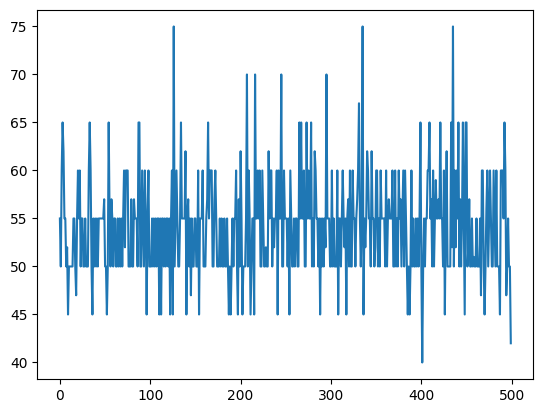

In [57]:
states_df['energy'].plot()

In [59]:
def check_sites_bonds():
    

42.0

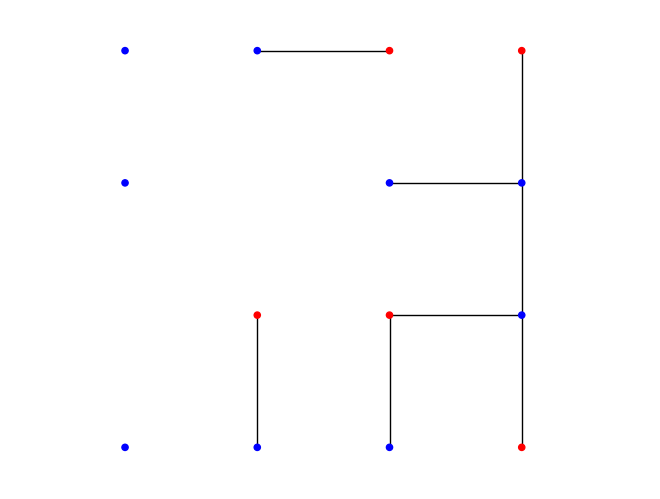

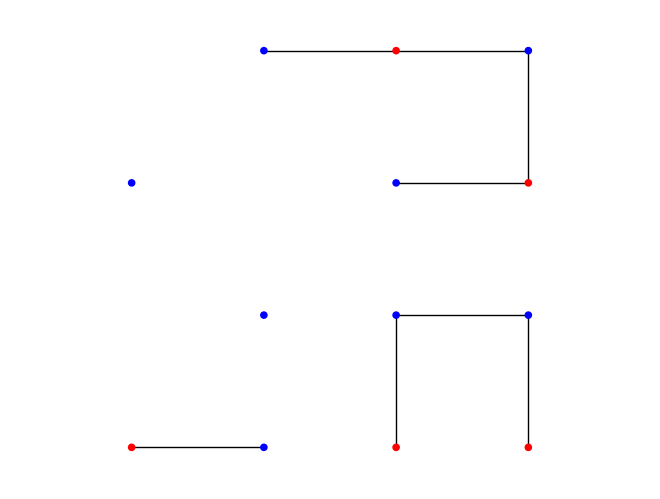

ValueError: 'c' argument has 13 elements, which is inconsistent with 'x' and 'y' with size 14.

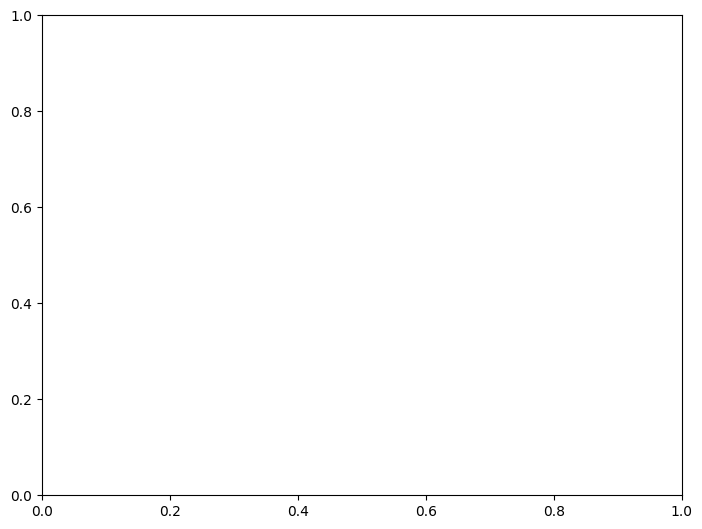

In [61]:
sol_structures = []
for dict in states_df.to_dict(orient='records'):
    if dict['energy'] < 55:
        structure = get_solution_structure(dict)
        sol_structures.append(structure)
        s,b,i,c = get_coords(structure[1],structure[2],structure[3])
        if len(s) == len(c):
            plot_solution(s,b,i,c,latticeSize)
        # try:
        #     plot_solution(s,b,i,c,latticeSize)
        #     # plot_solution(structure[0],structure[1],structure[2],colours,n)
        # except:
        #     print('plot failed')


In [ ]:
sites,bonds,interactions = states_df['sites'],states_df['bonds'],states_df['interactions']

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


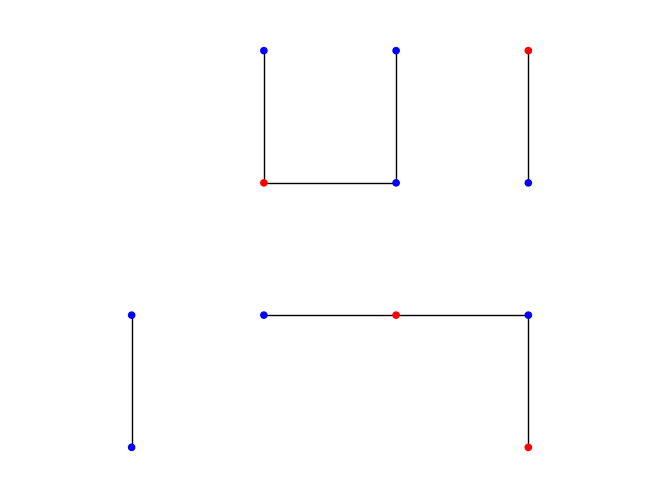

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


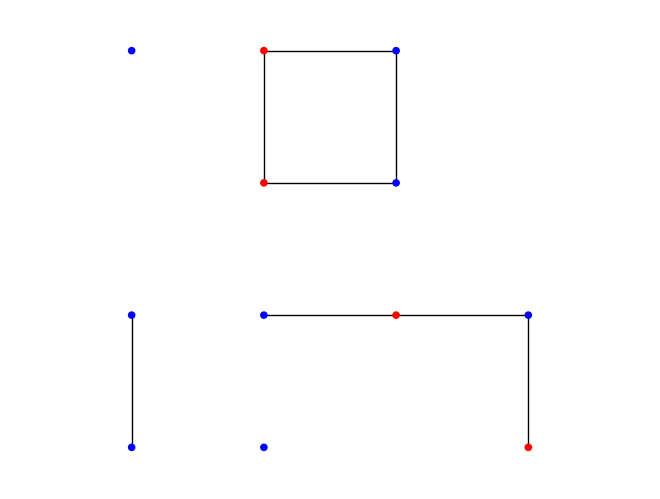

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


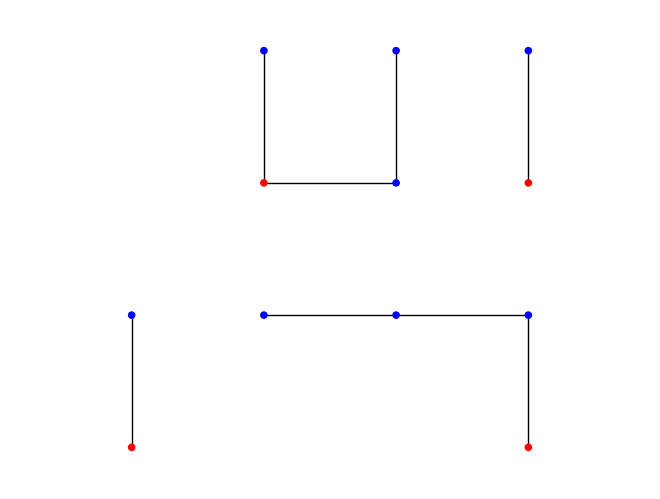

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


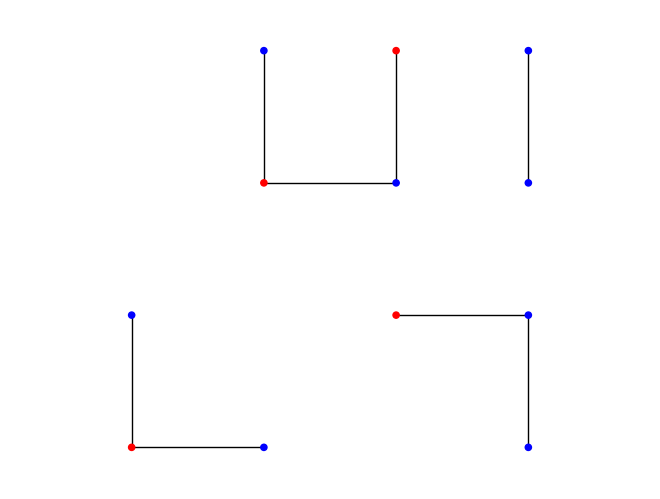

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]
number [] has failed
[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


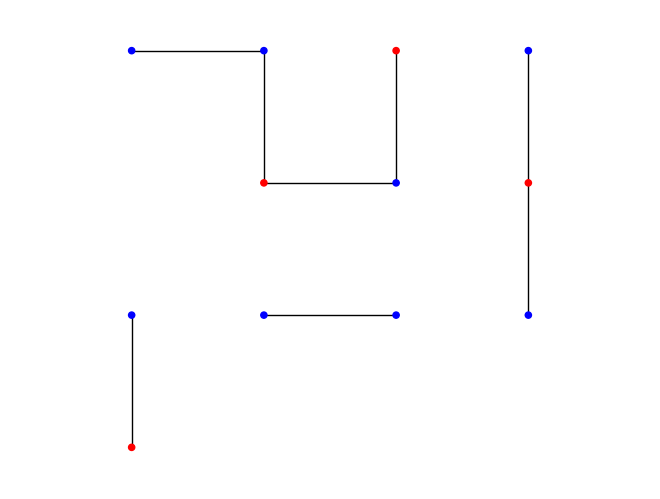

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]
number [] has failed
[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


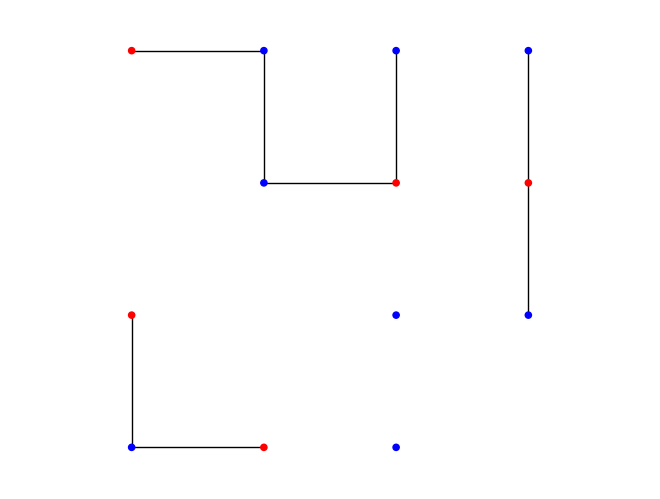

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


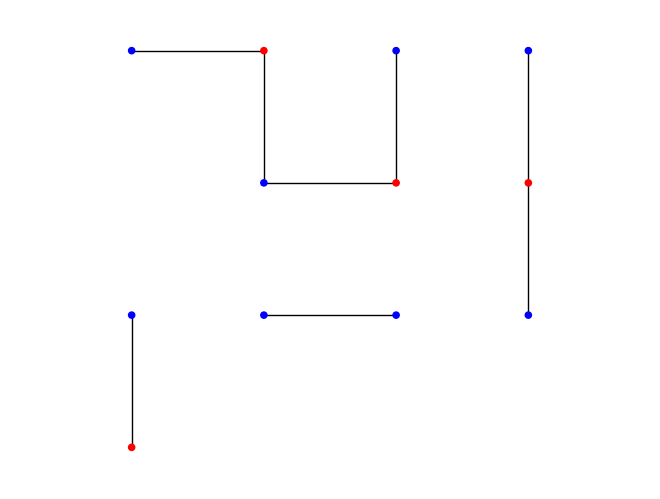

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


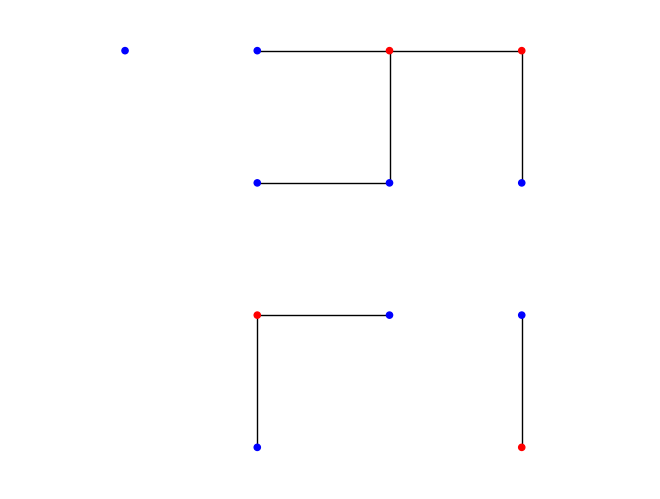

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


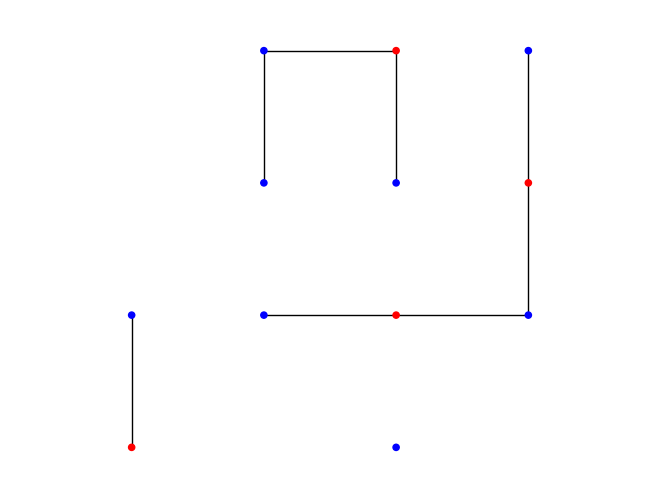

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]
number [] has failed
[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


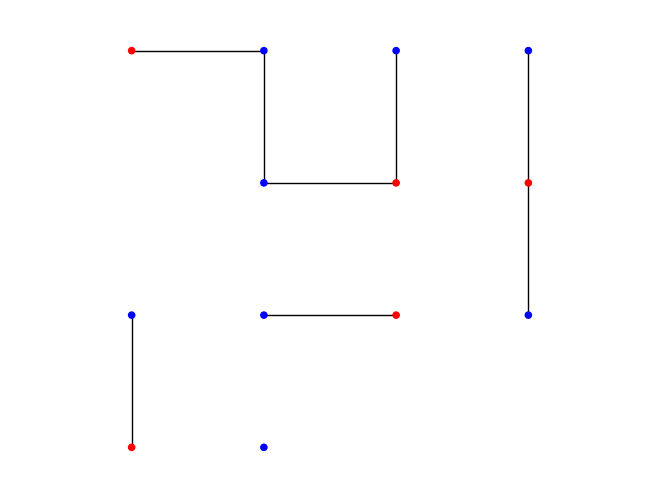

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


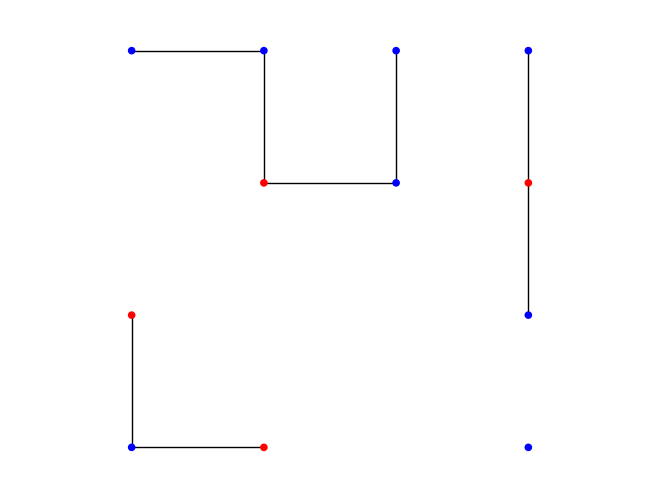

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]
number [] has failed
[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


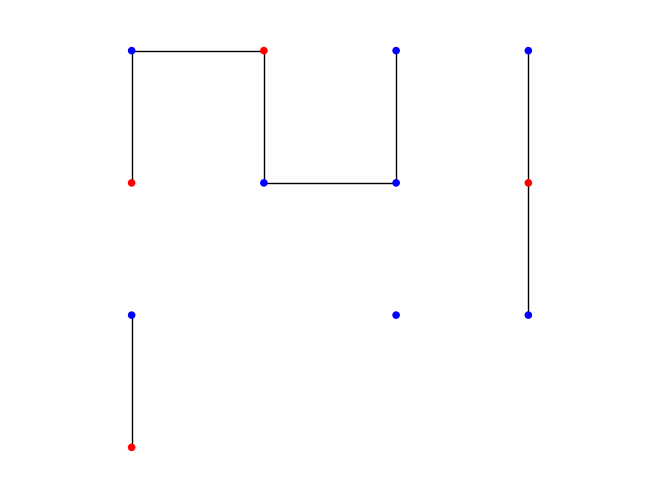

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


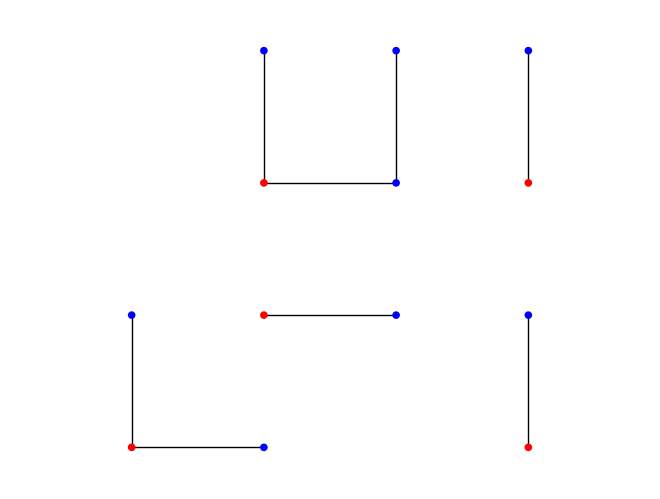

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]
number [] has failed
[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]
number [] has failed
[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]
number [] has failed
[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


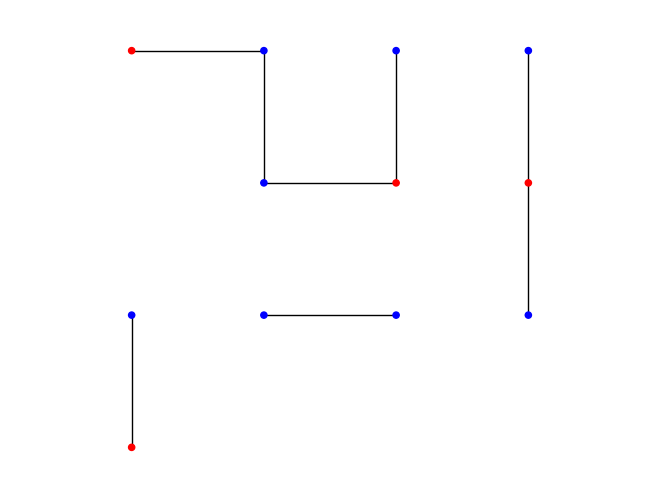

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


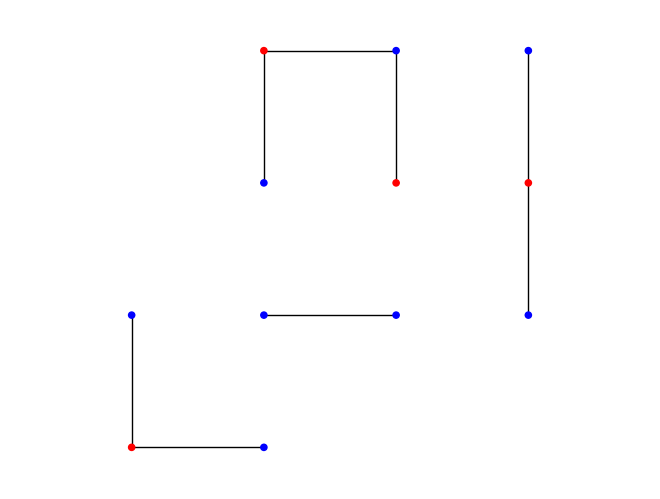

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


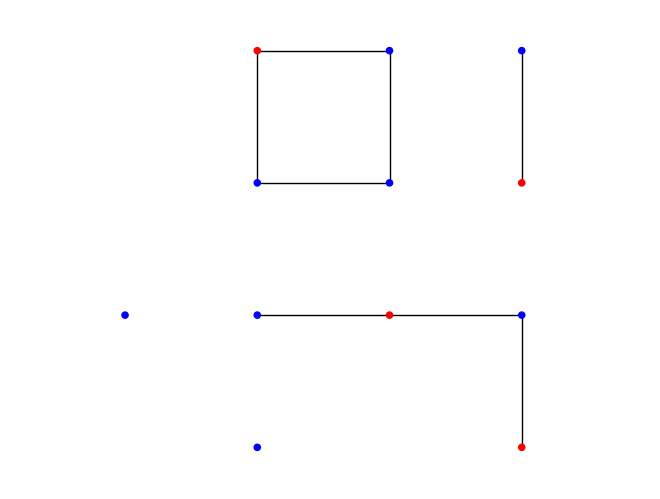

[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]


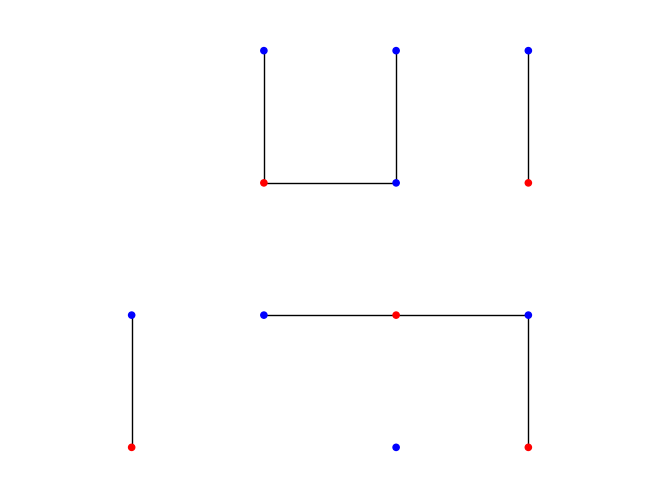

In [ ]:
n = latticeSize
for i in range(len(sites)):
    print(sites[0])
    s,b,i,c = get_coords(make_list(sites[i]),make_list(bonds[i]),make_list(interactions[i]))
    try:
        plot_solution(s,b,i,c,latticeSize)
    except:
        print(f'number {i} has failed')

In [ ]:
i

"[['0', 'O'], ['10', 'O'], ['11', 'O'], ['12', 'H'], ['13', 'O'], ['14', 'O'], ['15', 'H'], ['1', 'O'], ['5', 'O'], ['6', 'H'], ['7', 'O'], ['9', 'H']]"

In [ ]:
active_coords = []
for i in sites:
    active_coords.append(coords(i[0],n))
    if i[1] == 'H':
        colours_coords.append('red')
active_coords

ValueError: invalid literal for int() with base 10: '['

In [ ]:
def are_edges_valid(vertices, edges):
    # Convert the vertices list to a set of tuples for faster membership checking
    valid_vertices = set(map(tuple, vertices))

    # Iterate through the edges and check if both vertices are in the set of valid vertices
    for edge in edges:
        vertex1 = (edge[0], edge[2])  # Extract the first vertex as a tuple
        vertex2 = (edge[1], edge[3])  # Extract the second vertex as a tuple
        if vertex1 not in valid_vertices or vertex2 not in valid_vertices:
            return False  # At least one vertex is not in the valid vertices set

    return True  # All edges have valid vertices

# Example usage:
vertices = [['0', 'R'], ['1', 'B'], ['2', 'G']]
edges = [['0', '1', 'R', 'B'], ['0', '2', 'R', 'G'], ['1', '2', 'B', 'G']]

result = are_edges_valid(vertices, edges)
print(result)  # Output should be True in this example

True


In [ ]:
# def get_random_walk_bqm(n,N,L,Am,Ab,I,Asa,A2,A3,A4,L4,L6,BC,c_count,colours):
#     '''
#     LOGIC:
#         We create expressions for the model potentials term by term as given in the C.M paper "Polymer Physics".

#     INPUTS:
#         colours : List of letters ['R','G','B',...]
#         n   : Lattice dimension (nxn)
#         N   : List of the number of occupied vertices for each colour
#         L   : List of the number of occupied bonds for each colour
#         Am  : List of lattice energies for each colour
#         Ab  : Dictionary of pairwise bond strengths
#         Asa : Self avoiding energy
#         A2  : Vertex - bond coupling energy
#         A3  : Bond - rank 3 tensor coupling strength
#         A4  : Rank 3 - rank 4 tensor coupling strength
#         L4  : Length 4 walk cost
#         L6  : Length 6 walk cost
#         BC  : Type of boundary condition

#     OUTPUTS:
#         BQM : Binary Quadratic Model
#     '''
#     #colours are the representations of each type of ball
#     #n is the size of the grid
#     #N is the list of numbers of active sites for each colour
#     #L is the number of bonds
#     #Am is the monomer strength
#     #Ab is the bond strength
#     #A2 is the rank 1-2 tensor consistency bias
#     #Asa is the self avoiding walk bias
#     #A3 is the rank 2-3 tensor consistency bias

#     X = list(range(n**2)) #Vertex set

#     #Initialise BQM
#     '''
#     Initialise a BQM as a BINARY model (alternatively ISING)
#     '''
#     bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)


#     '''
#     Select N verticies from the vertex set X with energy Am using eqn (1)
#     '''
#     #V_mon
#     if sum(N) > n**2:
#         print('Too many sites are occupied, ensure the total is less than n^2')
#         return

#     #Fix total number of site
#     V_mon_total =  combinations([f'G_{i}_{c}' for i in range(n**2) for c in colours], sum(N), strength = 50)
#     bqm.update(V_mon_total)

#     # #Fix the number of sites of each colour
#     # for c,N_c in enumerate(N):
#     #     V_mon = combinations([f'G_{i}_{colours[c]}' for i in X], N_c, strength = 1)
#     #     bqm.update(V_mon)

#     #fix one colour per site
#     for i in X:
#         V_singlet =  combinations([f'G_{i}_{C}' for C in colours], 1, strength = 50)
#         bqm.update(V_singlet)
#         # print([f'{i}_{C}' for i in X for C in colours])


#     #V_bond
#     '''
#     Select L bonds from the bond set bond_list with energy Ab using eqn (2)
#     '''
#     bond = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     bond_list = get_all_bonds_global(n,colours) #All bonds
#     for c_pair in [key for key in Ab.keys()]:
#         sub_bond_list = [bond for bond in bond_list if bond.split('_')[3:] == c_pair.split(',') or bond.split('_')[3:] == c_pair.split(',').reverse()]
#         print('c_pair', c_pair)
#         V_bond = combinations(list(set(sub_bond_list)), L[f'{c_pair}'], strength = Ab[f'{c_pair}']) #Get BQM for L combinations of all bonds
#         # print('V_bond : ', V_bond)
#         bond.update(V_bond)
#         bqm.update(V_bond) # Update the main BQM

#     #Fix total number of bonds
#     V_bond_total =  combinations(get_all_bonds_global(n,colours), sum([l for l in L.values()]), strength = 10)
#     bqm.update(V_bond_total)



#     # print('V_bond :',  bond)

#     # #V_int
#     # '''
#     # Select I_n bonds from the bond set bond_list with energy I_v
#     # '''
#     # bqm_V_inter = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # inter_list = get_all_non_bond_interactions(n,colours) #All interactions
#     # for c_pair in [key for key in I.keys()]:
#     #     sub_int_list = [inter for inter in inter_list if inter.split('_')[3:] == c_pair.split(',') or inter.split('_')[3:] == c_pair.split(',').reverse()]
#     #     V_inter = combinations(list(set(sub_int_list)), L[f'{c_pair}'], strength = I[f'{c_pair}']) #Get BQM for L combinations of all bonds
#     #     bqm.update(V_inter) # Update the main BQM
#     #     bqm_V_inter.update(V_inter)

#     # for i in X:
#     #     for j in X:
#     #         int_on_i_j = [f'I_{i}_{j}_{c1}_{c2}' for c1 in colours for c2 in colours]
#     #         # print(int_on_i_j)
#     #         bqm.update(combinations(list(set(int_on_i_j)), 1, strength = 1))
#     # # print('V_inter :', bqm_V_inter)


#     #V_2 - consistancy relation between 2 sites and 1 bond
#     '''
#     Ensure that each bond is flanked by two valid vertices, for each bond I use the decompose_bond function to find the corresponding vericies then I apply (3).
#     '''
#     V_2 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     for bond in get_all_bonds_global(n,colours): # iterate over all bonds
#         i,j = decompose_bond(bond) # get both ends of the bond (verticies)
#         V_2.add_linear(bond,A2) # linear cost for bonds
#         V_2.add_quadratic(bond,i, - A2/2) # quadratic cost for each edge and their mother bond
#         V_2.add_quadratic(bond,j, - A2/2)
#         # print(i,j,bond)
#     bqm.update(V_2)

#     # # # V_2 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # # for bond in get_all_bonds_global(n,colours): # iterate over all bonds
#     # #     i,j = decompose_bond(bond) # get both ends of the bond (verticies)
#     # #     V_2.add_linear(bond,A2) # linear cost for bonds
#     # #     V_2.add_linear(i,A2)
#     # #     V_2.add_linear(j,A2)
#     # #     V_2.add_quadratic(bond,i, - A2) # quadratic cost for each edge and their mother bond
#     # #     V_2.add_quadratic(bond,j, - A2)
#     # #     V_2.add_quadratic(i,j, - A2)
#     # # bqm.update(V_2)




#     # # print('V_2:', V_2)

#     # # #I_V_2 - consistancy relation between 2 sites and 1 interaction
#     # # '''
#     # # Ensure that each interaction is flanked by two valid vertices
#     # # '''
#     # # I_V_2 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # # for inter in get_all_non_bond_interactions(n,colours): # iterate over all interactions
#     # #     i,j = decompose_bond(inter) # get both ends of the interaction (verticies)
#     # #     I_V_2.add_linear(inter,1) # linear cost for bonds
#     # #     I_V_2.add_quadratic(inter,i, - A2/2) # quadratic cost for each edge and their mother bond
#     # #     I_V_2.add_quadratic(inter,j, - A2/2)
#     # # bqm.update(I_V_2)

#     # # # print('I_V_2:', I_V_2)

#     #V_SA
#     '''
#     Penalise the intersection of rank three tensors of the form G_i_j_k G_l_j_m (branching terms) with energy Asa by applying eqn(4).
#     This is done by finding the set of binary tensors centered at vertex j and adding a quadratic interaction between each combination of them (combinations of length 2).
#     '''
#     V_SA = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     for j in X:
#         _3_tensors = get_all_3_tensors(j,n,colours) # Get all rank 3 tensors around point j
#         # if len(_3_tensors) != 1: # If there is only one, skip
#         for a,b in it.combinations(_3_tensors,2): # iterate over all pairs with common middle nodes
#             if a[:-2*len(colours)] != b[:-2*len(colours)]:
#                 print(a,b)
#                 V_SA.add_quadratic(a,b,Asa) # add quadratic interaction with strength Asa strength = Asa/(2*math.factorial(5))

#     bqm.update(V_SA)

#     print('V_SA :', V_SA)


#     # V_3 - consistancy relation between and walk of length 3 and the corresponding bonds
#     '''
#     Ensure that rank 3 tensor is flanked by two valid bonds, for each bond I use the decompose_3_tensor function to find the corresponding bonds then I apply (5).
#     '''
#     V_3 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     L = []
#     for j in X:
#         for c in colours:
#             for _3_tensors in get_all_3_tensors(j,n,colours): # get all rank 3 tensors
#                 tensor_decomp = decompose_3_tensor(_3_tensors) # get the bonds that make up each edge
#                 V_3.add_linear(_3_tensors,6) # linear cost for the rank 3 tensor ### ERROR FOUND HERE ### missing factor of 3
#                 V_3.add_quadratic(tensor_decomp[0],tensor_decomp[1],1)
#                 V_3.add_quadratic(_3_tensors,tensor_decomp[0],-4)
#                 V_3.add_quadratic(_3_tensors,tensor_decomp[1],-4)
#                 L.append([_3_tensors,tensor_decomp])
#     # print('V_3 : ', V_3)
#     bqm.update(V_3)

#     # V_4 - consistancy relation between and walk of length 4 and the walk of length 4
#     V_4 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     for c in colours:
#         for j in X:
#             L = [] #troubleshooting list, used to ensure decompositions are correct
#             for _4_tensors in get_4_tensors(j,n,colours): # iterate over all length 4 tensors with interior point j
#                 tensor_decomp = decompose_4_tensors(_4_tensors,n) # get the decomposition of every rank 4 tensor, these should be rank three tensors.
#                 V_4.add_linear(_4_tensors,A3/math.factorial(3)) # apply eqn (6)
#                 V_4.add_quadratic(tensor_decomp[0],tensor_decomp[1],A4/math.factorial(3))
#                 V_4.add_quadratic(_4_tensors,tensor_decomp[0],-2*A4/math.factorial(3))
#                 V_4.add_quadratic(_4_tensors,tensor_decomp[1],-2*A4/math.factorial(3))
#                 L.append([_4_tensors,tensor_decomp])
#     bqm.update(V_4)
#     # print('V_4 : ', V_4)


#     # ################################################SQUARE ICE/WATER TERMS################################################
#     '''
#     All of the following terms are to create square water
#     '''
#     # # Ban all straight edges by adding a linear cost
#     # straight_penality = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # S = []
#     # for j in X:
#     #     S += get_all_straight_3_tensors(j,n,colours)
#     # for s in S:
#     #     straight_penality.add_linear(s,1)

#     # bqm.update(straight_penality)


#     # #Add a linear cost for all of the non-bonded interactions
#     # for i in X:
#     #     for c1 in colours:
#     #         for j in next_to((i,c1),n,T=BC):
#     #             for c2 in colours:
#     #                 if f'{c1},{c2}' in I.keys():
#     #                     pass
#     #                 else:
#     #                     c1,c2 = c2,c1
#     #                 bqm.add_linear(f'I_{i}_{j}_{c1}_{c2}',I[f'{c1},{c2}'])


#     # # Prevent bonds that are not part of corners - specify the number of corners
#     # corners = []
#     # for j in X:
#     #     corners += get_all_corners(j,n,colours)
#     # corner_bqm = combinations(corners,c_count,1)
#     # bqm.update(corner_bqm)


#     # Ban all walks of length 4 with a linear cost
#     _4_walks_penalty = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     for j in X:
#         for t_4 in get_4_tensors(j,n,colours): # iterate over all length 4 tensors with interior point j
#             _4_walks_penalty.add_linear(t_4,1)
#     bqm.update(_4_walks_penalty)

#     # print('BQM complete')
#     return bqm

In [ ]:
# random_walk_bqm = get_random_walk_bqm(n,N,L,Am,Ab,I,Asa,A2,A3,A4,L4,L6,BC,c_count,colours)


In [ ]:
# BC = 'Default'
# # BC = 'Periodic'

# n = 3

# # def run_program(n,N,L,Am,Ab,I,Asa,A2,A3,A4,L4,L6,BC,c_count,colours):

# # protein problem:
# # colours = ['H','P','Po','Ne']
# # N = [4,4,4,4] #[H,P,Po,Ne]
# # L = {'H,P': 2,'H,Po':3, 'H,Ne' : 3, 'P,Po' : 3, 'Po, Ne' : 0}
# # Ab = {'H,P': 50,'H,Po':50, 'H,Ne' : 50, 'P,Po' : 50, 'Po, Ne' : 50}
# # I = {'H,P': -1,'H,Po':1, 'H,Ne' : 1, 'P,Po' : 1, 'Po, Ne' : -1}
# # Am = [1,1,1,1]


# # Square water
# colours = ['O']
# N = [6] #[O, H]
# L = {'O,H': 0,'O,O': 6, 'H,H' : 0}
# Am = [1,1]
# Ab= {'O,H': 50,'O,O': 50, 'H,H' : 50}
# I = {'O,H': 1,'O,O': -1, 'H,H' : -1}
# Asa= 0
# A2= 30
# A3= 1
# c_count = 10
# A4= 1
# L4= 1
# L6= 1

# repeats = 1

# random_walk_bqm = get_random_walk_bqm(n,N,L,Am,Ab,I,Asa,A2,A3,A4,L4,L6,BC,c_count,colours)



In [ ]:
# # Define the workflow
# iteration = hybrid.RacingBranches(
#     hybrid.InterruptableTabuSampler(),
#     hybrid.EnergyImpactDecomposer(size=2)
#     | hybrid.QPUSubproblemAutoEmbeddingSampler()
#     | hybrid.SplatComposer()
# ) | hybrid.ArgMin()
# workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=10)

# # Solve the problem
# init_state = hybrid.State.from_problem(random_walk_bqm)
# final_state = workflow.run(init_state).result()

# # Print results
# print("Solution: sample={.samples.first}".format(final_state))


In [ ]:
# sampler = KerberosSampler()

# solution = KerberosSampler().sample(random_walk_bqm, num_reads = repeats)

# solution_dataframe = solution.to_pandas_dataframe()

# all_solutions = []
# all_energy_num = []
# for i in range(solution_dataframe.shape[0]):
#     all_solutions.append(solution_dataframe.iloc[0,:-2].to_dict())
#     all_energy_num.append(solution_dataframe.iloc[0,-2:].to_dict())

# solution_dataframe = solution.to_pandas_dataframe()
# all_solutions = []
# all_energy_num = []
# for i in range(solution_dataframe.shape[0]):
#     all_solutions.append(solution_dataframe.iloc[0,:-2].to_dict()) #[{'G_i' : 1,'G_j' : 2, ... , ('G_i_j_k','G_j_k_l') : 1.333},....]
#     all_energy_num.append(solution_dataframe.iloc[0,-2:].to_dict()) #[num_occ : 10, energy : -15, ... , etc]

In [ ]:
# solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(final_state.samples.first[0])
# s,b,i,c = get_coords(sites,bonds,interactions)
# plot_solution(s,b,i,c,n)

In [ ]:
# for j in range(repeats):
#     solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(all_solutions[j])
#     s,b,i,c = get_coords(sites,bonds,interactions)
#     print(s,b,c)
#     print(f'Output {j} has {len(sites)} site and {len(bonds)} bonds')
#     plot_solution(s,b,i,c,n)

In [ ]:
# for j in range(repeats):
#     solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(all_solutions[j])
#     s,b,i,c = get_coords(sites,bonds,interactions)
#     print(s,b,c)
#     print(f'Output {j} has {len(sites)} site and {len(bonds)} bonds')
#     plot_solution(s,b,i,c,n)

In [ ]:
# for j in range(repeats):
#     solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(all_solutions[j])
#     s,b,i,c = get_coords(sites,bonds,interactions)
#     # print(s,b,c)
#     print(f'Output {j} has {len(sites)} site and {len(bonds)} bonds')
#     plot_solution(s,b,i,c,n)

In [ ]:
# def get_random_walk_bqm(n,N,L,Am,Ab,I,Asa,A2,A3,A4,L4,L6,BC,c_count,colours):
#     '''
#     LOGIC:
#         We create expressions for the model potentials term by term as given in the C.M paper "Polymer Physics".

#     INPUTS:
#         colours : List of letters ['R','G','B',...]
#         n   : Lattice dimension (nxn)
#         N   : List of the number of occupied vertices for each colour
#         L   : List of the number of occupied bonds for each colour
#         Am  : List of lattice energies for each colour
#         Ab  : Dictionary of pairwise bond strengths
#         Asa : Self avoiding energy
#         A2  : Vertex - bond coupling energy
#         A3  : Bond - rank 3 tensor coupling strength
#         A4  : Rank 3 - rank 4 tensor coupling strength
#         L4  : Length 4 walk cost
#         L6  : Length 6 walk cost
#         BC  : Type of boundary condition

#     OUTPUTS:
#         BQM : Binary Quadratic Model
#     '''
#     #colours are the representations of each type of ball
#     #n is the size of the grid
#     #N is the list of numbers of active sites for each colour
#     #L is the number of bonds
#     #Am is the monomer strength
#     #Ab is the bond strength
#     #A2 is the rank 1-2 tensor consistency bias
#     #Asa is the self avoiding walk bias
#     #A3 is the rank 2-3 tensor consistency bias

#     X = list(range(n**2)) #Vertex set

#     #Initialise BQM
#     '''
#     Initialise a BQM as a BINARY model (alternatively ISING)
#     '''
#     bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)


#     '''
#     Select N verticies from the vertex set X with energy Am using eqn (1)
#     '''
#     #V_mon
#     if sum(N) > n**2:
#         print('Too many sites are occupied, ensure the total is less than n^2')
#         return

#     #Fix total number of site
#     V_mon_total =  combinations([f'G_{i}_{c}' for i in range(n**2) for c in colours], sum(N), strength = 10)
#     bqm.update(V_mon_total)

#     # #Fix the number of sites of each colour
#     # for c,N_c in enumerate(N):
#     #     V_mon = combinations([f'G_{i}_{colours[c]}' for i in X], N_c, strength = 1)
#     #     bqm.update(V_mon)

#     #fix one colour per site
#     for i in X:
#         V_singlet =  combinations([f'G_{i}_{C}' for C in colours], 1, strength = 10)
#         bqm.update(V_singlet)
#         # print([f'{i}_{C}' for i in X for C in colours])


#     #V_bond
#     '''
#     Select L bonds from the bond set bond_list with energy Ab using eqn (2)
#     '''
#     bond = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     bond_list = get_all_bonds_global(n,colours) #All bonds
#     for c_pair in [key for key in Ab.keys()]:
#         sub_bond_list = [bond for bond in bond_list if bond.split('_')[3:] == c_pair.split(',') or bond.split('_')[3:] == c_pair.split(',').reverse()]
#         print('c_pair', c_pair)
#         V_bond = combinations(list(set(sub_bond_list)), L[f'{c_pair}'], strength = Ab[f'{c_pair}']) #Get BQM for L combinations of all bonds
#         # print('V_bond : ', V_bond)
#         bond.update(V_bond)
#         bqm.update(V_bond) # Update the main BQM

#     #Fix total number of bonds
#     V_bond_total =  combinations(get_all_bonds_global(n,colours), sum([l for l in L.values()]), strength = 10)
#     bqm.update(V_bond_total)



#     # print('V_bond :',  bond)

#     # #V_int
#     # '''
#     # Select I_n bonds from the bond set bond_list with energy I_v
#     # '''
#     # bqm_V_inter = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # inter_list = get_all_non_bond_interactions(n,colours) #All interactions
#     # for c_pair in [key for key in I.keys()]:
#     #     sub_int_list = [inter for inter in inter_list if inter.split('_')[3:] == c_pair.split(',') or inter.split('_')[3:] == c_pair.split(',').reverse()]
#     #     V_inter = combinations(list(set(sub_int_list)), L[f'{c_pair}'], strength = I[f'{c_pair}']) #Get BQM for L combinations of all bonds
#     #     bqm.update(V_inter) # Update the main BQM
#     #     bqm_V_inter.update(V_inter)

#     # for i in X:
#     #     for j in X:
#     #         int_on_i_j = [f'I_{i}_{j}_{c1}_{c2}' for c1 in colours for c2 in colours]
#     #         # print(int_on_i_j)
#     #         bqm.update(combinations(list(set(int_on_i_j)), 1, strength = 1))
#     # # print('V_inter :', bqm_V_inter)


#     #V_2 - consistancy relation between 2 sites and 1 bond
#     '''
#     Ensure that each bond is flanked by two valid vertices, for each bond I use the decompose_bond function to find the corresponding vericies then I apply (3).
#     '''
#     V_2 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     for bond in get_all_bonds_global(n,colours): # iterate over all bonds
#         i,j = decompose_bond(bond) # get both ends of the bond (verticies)
#         V_2.add_linear(bond,A2) # linear cost for bonds
#         V_2.add_quadratic(bond,i, - A2/2) # quadratic cost for each edge and their mother bond
#         V_2.add_quadratic(bond,j, - A2/2)
#         # print(i,j,bond)
#     bqm.update(V_2)

#     # # # V_2 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # # for bond in get_all_bonds_global(n,colours): # iterate over all bonds
#     # #     i,j = decompose_bond(bond) # get both ends of the bond (verticies)
#     # #     V_2.add_linear(bond,A2) # linear cost for bonds
#     # #     V_2.add_linear(i,A2)
#     # #     V_2.add_linear(j,A2)
#     # #     V_2.add_quadratic(bond,i, - A2) # quadratic cost for each edge and their mother bond
#     # #     V_2.add_quadratic(bond,j, - A2)
#     # #     V_2.add_quadratic(i,j, - A2)
#     # # bqm.update(V_2)




#     # # print('V_2:', V_2)

#     # # #I_V_2 - consistancy relation between 2 sites and 1 interaction
#     # # '''
#     # # Ensure that each interaction is flanked by two valid vertices
#     # # '''
#     # # I_V_2 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # # for inter in get_all_non_bond_interactions(n,colours): # iterate over all interactions
#     # #     i,j = decompose_bond(inter) # get both ends of the interaction (verticies)
#     # #     I_V_2.add_linear(inter,1) # linear cost for bonds
#     # #     I_V_2.add_quadratic(inter,i, - A2/2) # quadratic cost for each edge and their mother bond
#     # #     I_V_2.add_quadratic(inter,j, - A2/2)
#     # # bqm.update(I_V_2)

#     # # # print('I_V_2:', I_V_2)

#     #V_SA
#     '''
#     Penalise the intersection of rank three tensors of the form G_i_j_k G_l_j_m (branching terms) with energy Asa by applying eqn(4).
#     This is done by finding the set of binary tensors centered at vertex j and adding a quadratic interaction between each combination of them (combinations of length 2).
#     '''
#     V_SA = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     for c in colours:
#         for j in X:
#             _3_tensors = get_all_3_tensors(j,n,colours) # Get all rank 3 tensors around point j
#             if len(_3_tensors) != 1: # If there is only one, skip
#                 for a,b in it.combinations(_3_tensors,2): # iterate over all pairs with common middle nodes
#                     if a[:-2*len(colours)] != b[:-2*len(colours)]:
#                         print(a,b)
#                         V_SA.add_quadratic(a,b,Asa) # add qaudratic interaction with strength Asa strength = Asa/(2*math.factorial(5))

#     bqm.update(V_SA)

#     # print('V_SA :', V_SA)


#     # V_3 - consistancy relation between and walk of length 3 and the corresponding bonds
#     '''
#     Ensure that rank 3 tensor is flanked by two valid bonds, for each bond I use the decompose_3_tensor function to find the corresponding bonds then I apply (5.
#     '''
#     V_3 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     L = []
#     for j in X:
#         for c in colours:
#             for _3_tensors in get_all_3_tensors(j,n,colours): # get all rank 3 tensors
#                 tensor_decomp = decompose_3_tensor(_3_tensors) # get the bonds that make up each edge
#                 V_3.add_linear(_3_tensors,6) # linear cost for the rank 3 tensor ### ERROR FOUND HERE ### missing factor of 3
#                 V_3.add_quadratic(tensor_decomp[0],tensor_decomp[1],1)
#                 V_3.add_quadratic(_3_tensors,tensor_decomp[0],-4)
#                 V_3.add_quadratic(_3_tensors,tensor_decomp[1],-4)
#                 L.append([_3_tensors,tensor_decomp])
#     # print('V_3 : ', V_3)
#     bqm.update(V_3)

#     # # V_4 - consistancy relation between and walk of length 4 and the walk of length 4
#     # V_4 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # for c in colours:
#     #     for j in X:
#     #         L = [] #troubleshooting list, used to ensure decompositions are correct
#     #         for _4_tensors in get_4_tensors(j,n,colours): # iterate over all length 4 tensors with interior point j
#     #             tensor_decomp = decompose_4_tensors(_4_tensors,n) # get the decomposition of every rank 4 tensor, these should be rank three tensors.
#     #             V_4.add_linear(_4_tensors,A3/math.factorial(3)) # apply eqn (6)
#     #             V_4.add_quadratic(tensor_decomp[0],tensor_decomp[1],A4/math.factorial(3))
#     #             V_4.add_quadratic(_4_tensors,tensor_decomp[0],-2*A4/math.factorial(3))
#     #             V_4.add_quadratic(_4_tensors,tensor_decomp[1],-2*A4/math.factorial(3))
#     #             L.append([_4_tensors,tensor_decomp])
#     # bqm.update(V_4)
#     # # print('V_4 : ', V_4)


#     # ################################################SQUARE ICE/WATER TERMS################################################
#     '''
#     All of the following terms are to create square water
#     '''
#     # # Ban all straight edges by adding a linear cost
#     # straight_penality = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # S = []
#     # for j in X:
#     #     S += get_all_straight_3_tensors(j,n,colours)
#     # for s in S:
#     #     straight_penality.add_linear(s,1)

#     # bqm.update(straight_penality)


#     # #Add a linear cost for all of the non-bonded interactions
#     # for i in X:
#     #     for c1 in colours:
#     #         for j in next_to((i,c1),n,T=BC):
#     #             for c2 in colours:
#     #                 if f'{c1},{c2}' in I.keys():
#     #                     pass
#     #                 else:
#     #                     c1,c2 = c2,c1
#     #                 bqm.add_linear(f'I_{i}_{j}_{c1}_{c2}',I[f'{c1},{c2}'])


#     # # Prevent bonds that are not part of corners - specify the number of corners
#     # corners = []
#     # for j in X:
#     #     corners += get_all_corners(j,n,colours)
#     # corner_bqm = combinations(corners,c_count,1)
#     # bqm.update(corner_bqm)


#     # # Ban all walks of length 4 with a linear cost
#     # _4_walks_penalty = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
#     # for j in X:
#     #     for t_4 in get_4_tensors(j,n,colours): # iterate over all length 4 tensors with interior point j
#     #         _4_walks_penalty.add_linear(t_4,-1)
#     # bqm.update(_4_walks_penalty)

#     # print('BQM mplete')
#     return bqm

In [ ]:
# def get_solution_structure(solution_dict):
#     solution_list = [k.split('_') for k, v in solution_dict.items() if v == 1]
#     sites = [tensor[1:] for tensor in solution_list if len(tensor) == 3 and tensor[0] == 'G']
#     bonds = [tensor[1:] for tensor in solution_list if len(tensor) == 5 and tensor[0] == 'G']
#     corners = [tensor[1:] for tensor in solution_list if len(tensor) == 6 and tensor[0] == 'G']
#     rank_4 = [tensor[1:] for tensor in solution_list if len(tensor) == 8 and tensor[0] == 'G']
#     interactions = [tensor[1:] for tensor in solution_list if len(tensor) == 5 and tensor[0] == 'I']
#     return solution_list, sites, bonds, corners, rank_4, interactions


# for i in range(repeats):
#     solution_list,sites, bonds, corners, rank_4, interactions = get_solution_structure(all_solutions[i])
#     s,b,i,c = get_coords(sites,bonds,interactions)
#     # print(s,b,c)
#     print(f'Output {i} has {len(sites)} site and {len(bonds)} bonds')
#     plot_solution(s,b,i,c,n)